In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_csv(filename):
    csv_path = os.path.join(labels_path, filename)
    return pd.read_csv(csv_path)

In [15]:
def extract_originals_and_labels(filename, folder, count):
    ROIs = load_csv(filename)
    originals_folder = os.path.join(originals_path, folder)
    labels_folder = os.path.join(labels_path, folder)
    
    for index, row in ROIs.iterrows():
        #print(count + index, index, row['label'], row['sample'])
        I = plt.imread(originals_folder + row['label'] + '.tif')
        I_green = I[:,:,1]
        roi = I_green[row['ycoord'] : row['ycoord'] + height,
                  row['xcoord'] : row['xcoord'] + width]
        roi = roi.reshape(1, height * width)
        originals[count + index, :] = roi

        I = plt.imread(labels_folder + row['label'] + '_' + str(row['sample']) + '_' + 'skeletone.jpg')
        I_grey = np.dot(I[...,:3], [0.299, 0.587, 0.114])
        roi = I_grey[0 : height, 0 : width]
        roi = roi.reshape(1, height * width)
        labels[count + index, :] = roi
    count += index + 1
    return originals, labels, count

## Prepare datasets

In [12]:
originals_path = '/Users/vladarozova/Dropbox/PhD/angiogenesis/originals'
labels_path = '/Users/vladarozova/Dropbox/PhD/angiogenesis/Anna\'s results'
output = '/Users/vladarozova/Dropbox/PhD/angiogenesis/datasets'

height = 156
width = 155
N_instances = 30 + 30 + 37 + 39

originals = np.zeros((N_instances, height * width), dtype = np.int)
labels = np.zeros((N_instances, height * width), dtype = np.int)
originals.shape, labels.shape

((136, 24180), (136, 24180))

In [13]:
count = 0
originals, labels, count = extract_originals_and_labels('PE8_ROIs.csv', 'plaineggED8/', count)
originals, labels, count = extract_originals_and_labels('PE12_ROIs.csv', 'plaineggED12/', count)
originals, labels, count = extract_originals_and_labels('CS8_ROIs.csv', 'cellsuspensionED8/', count)
originals, labels, count = extract_originals_and_labels('CS12_ROIs.csv', 'cellsuspensionED12/', count)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/vladarozova/Dropbox/PhD/angiogenesis/samples for ridge detection/plaineggED8/egg36.tif'

In [5]:
print(originals.shape)
print(originals)

(136, 24180)
[[102 102 101 ..., 164 166 167]
 [108 108 111 ..., 151 152 153]
 [148 147 146 ..., 115 113 110]
 ..., 
 [117 117 120 ..., 134 131 128]
 [ 73  75  75 ..., 127 122 118]
 [137 136 136 ..., 146 148 149]]


In [6]:
binary_labels = 0 * (labels < 128) + 1 * (labels >= 128)

In [ ]:
# Doesn't work properly!!!
np.savetxt("originals.csv", originals, delimiter = ",")
np.savetxt("labels.csv", labels, delimiter = ",")

## Visualise 

In [7]:
def plot_image(some_instance):
    some_image = some_instance.reshape(height, width)
    plt.imshow(some_image, cmap = plt.cm.gray, interpolation = "nearest")
    plt.axis("off")
    plt.show()

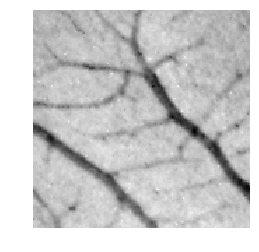

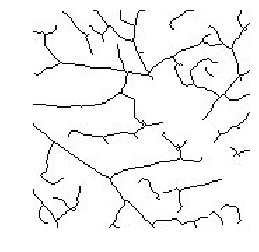

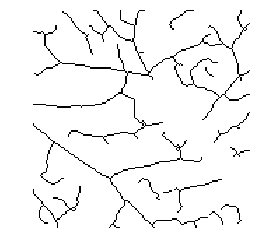

In [8]:
some_instance = 55
plot_image(originals[some_instance, :])
plot_image(labels[some_instance, :])
plot_image(binary_labels[some_instance, :])

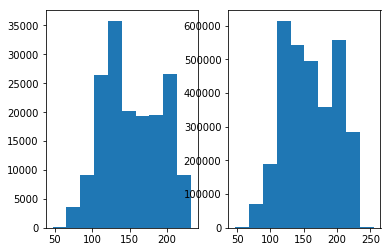

In [9]:
plt.subplot(121)
plt.hist(originals[binary_labels == 0])
plt.subplot(122)
plt.hist(originals[binary_labels == 1])

#plt.scatter(binary_labels[some_instance, :],originals[some_instance, :])
plt.show()

## Create a test set

In [54]:
def split_train_test(data, target, train_ratio):
    np.random.seed(42)
    shuffle_index = np.random.permutation(len(data))
    X = data[shuffle_index]
    y = target[shuffle_index]
    train_set_size = int(len(data) * train_ratio)
    print(train_set_size)
    return X[: train_set_size], X[train_set_size :], y[: train_set_size], y[train_set_size :]

X_train, X_test, y_train, y_test = split_train_test(originals, labels, 0.8)
#X_train, X_test, y_train, y_test = split_train_test(originals, binary_labels, 0.8)
print(len(X_train), "train +", len(X_test), "test")

108
108 train + 28 test


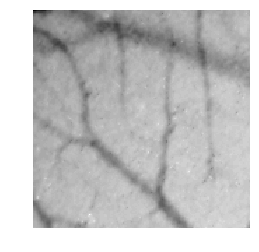

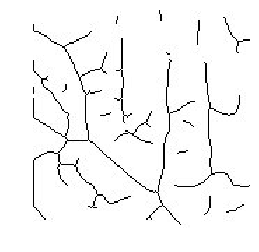

In [55]:
some_instance = 14
plot_image(X_train[some_instance, :])
plot_image(y_train[some_instance, :])

## Model selection

### Random Forest

In [ ]:
# Don't run it!
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train)

### K-neighbours

Fit the model

In [56]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=5, weights = 'distance')
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')

Predict and calculate RMSE

In [31]:
from sklearn.metrics import mean_squared_error

y_pred = knn_clf.predict(X_train)
knn_mse = mean_squared_error(y_train, y_pred)
knn_rmse = np.sqrt(knn_mse)
knn_rmse

0.0057719106602399329

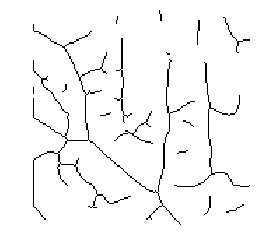

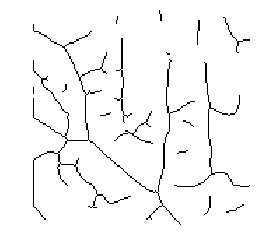

In [52]:
predicted_image = knn_clf.predict([X_train[some_instance]])
plot_image(y_train[some_instance])
plot_image(predicted_image)

Test the model

In [33]:
final_pred = knn_clf.predict(X_test)

final_mse = mean_squared_error(y_test, final_pred)
final_rmse = np.sqrt(final_mse)
final_rmse

0.22930083458235179

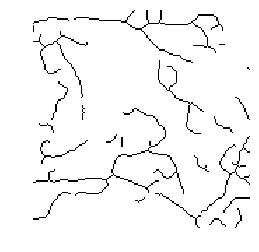

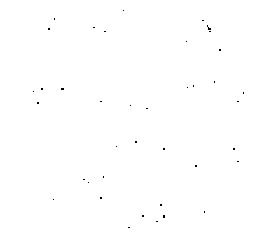

In [51]:
plot_image(y_test[some_instance])
plot_image(final_pred[some_instance])

Cross validation

In [53]:
from sklearn.model_selection import cross_val_score

knn_cv_mse = cross_val_score(knn_clf, X_train, y_train,
                        scoring = "neg_mean_squared_error", cv = 3)
knn_cv_rmse = np.sqrt(-knn_cv_mse)
knn_cv_rmse

array([ 0.23256945,  0.23409571,  0.23397299])

In [ ]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(knn_clf, X_train, y_train, cv = 3)

Grid search

In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_neighbors': [5], 'weights': ['distance']},
]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv = 5,
                          scoring = 'neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': [5], 'weights': ['distance']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [20]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

61.0751940157 {'n_neighbors': 5, 'weights': 'distance'}
